## Chap16 - 강화학습 (Reinforcement Learning)

- 강화 학습이 무엇인지 / 어떤 일을 잘할 수 있는지
- 심층 강화 학습에서 가장 중요한 두 가지 기술
    - 정책 그래디언트(policy gradient)
    - 심층 Q-네트워크(DQN_deep-Q-networks)
- 마르코프 결정 과정(MDP_Markov decision process)

## 1. 보상을 최적화하기 위한 학습

강화학습에서 소프트웨어 **에이전트**(agent)는 **관측**(observation)을 하고 주어진 **환경**(environment)에서 **행동**(action)한다. 그리고 그 결과로 **보상**(reward)을 받는다(그림 출처: [wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)).

![](./images/rl.png)

- 에이전트의 목적
    - 보상의 장기간(long-term) 기대치를 최대로 만드는 행동을 학습하는 것,
    - 에이전트는 환경안에서 행동하고 시행착오를 통해 보상이 최대가 되도록 학습.

- 강화 학습의 예
    - 보행 로봇
    - 미스 팩맨
    - 바둑 게임

## 2. 정책 탐색 (Policy Search)

- **정책(policy)** : 에이전트(agent)가 행동(action)을 결정하기 위해 사용하는 알고리즘
    - 예를 들어 관측(observation)을 입력으로 받고 행동(action)을 출력하는 신경망이 정책이 될 수 있다.

![](./images/rl03.PNG)

- Ex) 30분 동안 수집한 먼지의 양을 보상으로 받는 로봇 청소기
    - 매 초마다 어떤 확률로 $p$ 만큼 전진 
    - ($1-p$)의 확률로 랜덤하게 $-r$과 $+r$ 사이에서 회전하는 것
    - => 무작위성이 포함되어 있으므로 **확률적 정책**
    - 변경 가능한 두 개의 **정책 파라미터** 존재
    - 정책 파라미터의 범위 : **정책 공간**
    - 정책 공간에서 가장 성능이 좋은 파라미터를 찾는 것 : **정책 탐색**


- 정책 탐색 종류
    - **단순한(naive) 방법** : 다양한 파라미터 값들로 실험한 뒤 가장 성능이 좋은 파라미터를 선택
    - **유전 알고리즘(genetic algorithm)** :  기존의 정책(부모)에서 더 좋은 정책(자식)을 만들어 내는 과정(진화)를 통해서 좋은 정책을 찾을 때까지 반복하는 방법이다.
    - **정책 그래디언트(PG, policy gradient)** : 정책 파라미터에 대한 보상(reward)의 그래디언트(gradient)를 평가해서 높은 보상의 방향을 따르는 그래디언트로(**gradient ascent**) 파라미터를 업데이트하는 최적화 방법이다.

### Set Up

In [5]:
import os, sys
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# 맷플롯립 설정
from IPython.display import HTML
%matplotlib inline
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
# matplotlib.rc('font', family='NanumBarunGothic') # Linux
plt.rcParams['axes.unicode_minus'] = False

## 3. OpenAI Gym

강화학습에서 중요한 요소 중 하나는 에이전트(agent)를 훈련시키기 위한 **시뮬레이션 환경**이 필요하다.

**[OpenAI Gym](http://gym.openai.com)**은 다양한 종류의 시뮬레이션 환경(아타리 게임, 보드 게임, 물리 시뮬레이션 등)을 제공하는 툴킷이며, 이를 이용하여 에이전트를 훈련시키고 RL 알고리즘을 개발할 수 있다.

In [6]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # 문제없음, OpenAI 짐의 렌더링 함수를 사용합니다
except Exception:
    openai_cart_pole_rendering = False  # 가능한 X 서버가 없다면, 자체 렌더링 함수를 사용합니다

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # OpenAI 짐의 렌더링 함수를 사용합니다
        return env.render(mode="rgb_array")
    else:
        # Cart-Pole 환경을 위한 렌더링 (OpenAI 짐이 처리할 수 없는 경우)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # 파랑 초록 빨강
        pole_col = 0x669acc # 파랑 초록 빨강

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

obs.shape : (4,)
obs : [ 0.02964526 -0.02933668  0.03127396  0.0274764 ]
img.shape : (400, 600, 3)


C:\Users\user\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


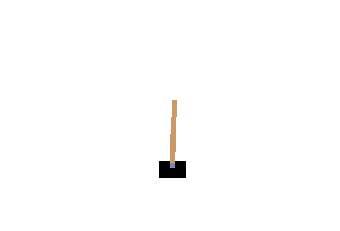

In [7]:
import gym

# 환경 생성
env = gym.make("CartPole-v0")
# reset으로 초기화
# obs = [카트의 수평 위치, 속도, 막대의 각도, 각속도]
obs = env.reset()
img = render_cart_pole(env, obs)

print('obs.shape :', obs.shape)
print('obs :', obs)
print('img.shape :', img.shape)
plot_cart_pole(env, obs)

CartPole의 환경에서는 어떤 행동(action)이 가능한지 `action_space`를 통해 확인할 수 있다.

In [8]:
print('env.action_space :', env.action_space)

env.action_space : Discrete(2)


`Discrete(2)`는 가능한 행동이 `0`(왼쪽)과 `1`(오른쪽)이라는 것을 의미한다. 아래의 코드에서 `step()` 메서드를  통해 막대를 오른쪽(`1`)으로 가속 시켜보자.

In [9]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)

print('obs :', obs)
print('reward :', reward)
print('done :', done)
print('info :', info)

obs : [ 0.02905853  0.16532315  0.03182349 -0.25517752]
reward : 1.0
done : False
info : {}


위의 출력결과 처럼, `step()` 메서드는 주어진 행동을 실행하고 `obs, reward, done, info` 4개의 값을 리턴한다.

- `obs` : 새로운 관측값
- `reward` : 행동에 대한 보상을 말하며, 여기서는 매 스텝마다 `1`의 보상을 받는다.
- `done` : 값이 `True` 이면, 에피소드(게임 한판)가 끝난것을 말한다. 여기서는 막대가 넘어진 경우를 말한다.
- `info` : 추가적인 디버깅 정보가 딕셔너리 형태로 저장된다. 여기서는 별도의 정보가 따로 없다.

## 4. 신경망 정책

- 정책(policy)을 **신경망(neural networks)**으로 적용

![](./images/rl-nn.PNG)

- 관측을 입력으로 받고 실행할 행동에 대한 **확률**을 출력
- 높은 확률을 실행하지 않고 랜덤하게 행동을 하는 이유는 에이전트가 새로운 행동을 **탐험(exploring)** 하는 것과 잘 할 수 있는 행동을 **활용(exploiting)**하는 것 사이에 균형이 잘 맞게끔 하기 위해서이다.

## 5. 행동평가: 신용 할당 문제

- 에이전트가 보상을 받았을 때 어떤 행동 때문에 받았는지 알기 어려운 것 : **신용 할당 문제(credit assignment problem)**
- 이러한 문제를 해결하기 위해 주로 사용하는 전략은 행동이 일어난 후 각 단계마다 **할인 계수(discount factor)** $\gamma$를 적용한 보상을 모두 합하여 행동을 평가하는 것

- 할인 계수의 역할
    - 할인 계수 $\gamma$가 `0`에 가까우면 미래의 보상은 현재의 보상보다는 중요하게 취급 되지 않는다.
    - `1`에 가까우면 미래의 보상이 현재의 보상만큼 중요하게 고려된다. 
    - 일반적으로 할인 계수는 `0.95 ~ 0.99` 이다.
      - $\gamma = 0.95$ 이면, 13 스텝만큼의 미래서 받는 보상은 당장 받는 보상에 비해 약 절반 정도의 가치가 된다($0.95^{13} \approx 0.5$).
![](./images/discount.PNG)

In [30]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [31]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

## 6. 정책 그래디언트 (PG, Policy Gradient)

- 정책 그래디언트(PG)는 높은 보상을 얻는 방향의 그래디언트로 정책(policy)의 파라미터를 최적화하는 알고리즘
- 인기 있는 PG 알고리즘 중 하나는 1992년에 로날드 윌리엄스가 소개한 **REINFORCE**

**REINFORCE**의 방법은 다음과 같다.

1. 먼저 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그래디언트를 계산한다. 
2. 몇 번의 에피소드를 실행한 다음, 각 행동의 점수를 계산한다. 
3. 한 행동 점수가 양수이면 선택될 가능성이 높도록 `1`번에서 계산한 그래디언트를 적용한다. 만약, 음수일 경우 덜 선택 되도록 반대의 그래디언트를 적용한다. 
   - 그래디언트 벡터와 행동 점수를 곱해주면 된다.
4. 마지막으로 모든 결과 그래디언트 벡터의 평균을 구한 다음 경사 하강법을 수행한다.

In [18]:
# 정규화를 통해 서로 비교
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

## 7. 마르코프 결정 과정(MDP)

20세기 초 수학자 Andrey Markov는 메모리가 없는 확률 과정(stochastic process)인 
- **마코프 체인(Markov Chain)** : 메모리가 없는 확률 과정
    - 정해진 개수의 상태(state)를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이되는 것
    - 상태 $s$에서 상태 $s'$로 전이하기 위한 확률은 고정
    - 메모리가 없기 때문에 과거 상태에 상관없이 $(s, s')$ 쌍에만 의존
    - => 이러한 성질을 **마코프 성질**(Markov property)

아래의 그림은 4개의 상태를 가진 마코프 체인의 예제다. 상태 $S_0$에서 시작한다고 했을 때, 다음 스텝에서 $S_0$에 있을 확률은 $0.7$이다. $0.2$의 확률로 $S_1$로 전이됐을 경우 $S_2$로 전이될 확률이 0.9이기 때문에 $S_2$로 갈 가능성이 높다. $S_2$로 갔을 경우 $1.0$의 확률로 다시 $S_1$로 돌아오게 된다. 만약, $0.1$의 확률로 $S_3$으로 전이 된다면, 영원히 $S_3$에 남게되는데, 이 상태를 **종료 상태(terminal state)**라고 한다.

![](./images/mc.PNG)

마코프 결정 과정(**MDP**, Markov Decision Process)은 1950년대 [Richard Bellman](https://goo.gl/wZTVIN)에 의해 처음 사용되었다. 마코프 체인과 비슷하지만 MDP는 다음과 같은 특징을 가진다.

- 각 스텝에서 에이전트(agent)는 여러 가능한 행동(action) 중 하나를 선택할 수 있다.
- 전이 확률은 선택된 행동에 따라 달라지며, 어떤 상태로의 전이는 보상(reward)을 반환한다. 
- 그리고 에이전트의 목적은 시간이 지남에 따라 보상을 최대화하기 위한 정책을 찾는 것이다.

- **최적의 상태 가치(optimal state value)** $V^{*}(s)$ : 에이전트가 상태 $s$ 에 도달한 후 최적으로 행동한다고 가정하고 평균적으로 기대할 수 있는 할인된 미래 보상(discounted future reward)의 합
- **벨만 최적 방정식(Bellman Optimality Equation)**
    - 에이전트가 최적으로 행동하면 현재 상태의 최적 가치는 하나의 최적 행동으로 인해 평균적으로 받게 될 보상
    - 이 행동이 유발할 수 있는 가능한 모든 다음 상태의 최적 가치의 기대치

$$
V^{*}(s) \leftarrow \max_{a}{\sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot V^{*}(s') \right]}}
$$

- $T(s,a,s')$ : 에이전트가 행동 $a$를 선택했을 때 상태 $s$ → $s'$로 전이될 확률
- $R(s,a,s')$ : 에이전트가 행동 $a$를 선택해서 상태 $s$ → $s'$로 이동했을 때의 보상
- $\gamma$ : 할인 계수



먼저, 모든 상태 가치를 `0`으로 초기화 한 뒤, 위의 식을 가지고 여러번 반복(value iteration)하여 상태 가치를 업데이트 해주게 되면, 최적의 상태 가치에 수렴하게 된다.
$$
V^{*}_{k+1}(s) \leftarrow \max_{a}{\sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot V^{*}_{k}(s') \right]}}
$$

- 최적의 상태 가치를 아는 것은 정책을 평가할 때 유용하지만, 에이전트는 어떻게 행동해야 하는지에 대해서는 알지못한다.
- Bellman은 **Q-Value**라고 부르는 최적의 **state-action value**를 추정할 수 있는 알고리즘을 만들었다. 
    - 상태-행동 $(s, a)$ 쌍의 최적의 Q-가치(Q-함수)인 $Q^{*}(s,a)$ 는 상태 $s$에 도달해서 행동 $a$를 선택하고 이 행동의 평균적으로 기대할 수 있는 할인된 미래 보상의 합이다. 여기서도 마찬가지로 에이전트가 이 행동 이후에 최적으로 행동할 것이라고 가정한다.

**Q-Value Iteration** 알고리즘 또한, Q-가치의 추정을 모두 `0`으로 초기화 한 후 아래의 식을 통해 업데이트 한다.


$$
Q_{k+1}(s, a) \leftarrow \sum_{s'}^{}{T(s,a,s')\left[ R(s,a,s') + \gamma \cdot \max_{a'}{Q_{k}(s', a')} \right]}
$$


최적의 Q-가치를 구하면 최적의 정책인 $\pi^{*} (s)$는 다음과 같다.
$$
\pi^{*}(s) = \underset{a}{\text{argmax}} Q^{*}(s,a) 
$$


위의 MDP 예제 그림에 대해 Q-value Iteration 알고리즘을 적용시킨 예제 코드다.

In [19]:
import numpy as np

nan = np.nan  # 불가능한 행동을 나타냄
T = np.array([  # 형태 = [s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
    ])
R = np.array([  # 형태 = [s, a, s']
        [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
        [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50]],
        [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
    ])
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [21]:
Q = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -inf
'''
array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])
'''

'\narray([[-inf, -inf, -inf],\n       [-inf, -inf, -inf],\n       [-inf, -inf, -inf]])\n'

In [22]:
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 모든 가능한 행동의 초기값 = 0.0 으로 설정

In [24]:
discount_factor = 0.95
n_iteration = 100

for iteration in range(n_iteration):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s, a, sp] * (R[s, a, sp] + discount_factor * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

In [25]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [26]:
np.argmax(Q, axis=1)  # 각 상태에서 최적의 행동

array([0, 2, 1], dtype=int64)

![](./images/mdp.PNG)

## 8. 시간차(Temporal Difference) 학습과 Q-Learning

- MDP 문제점
    - 학습 초기에 에이전트는 전이 확률($T(s, a, s')$)에 대해 알지 못하며, 보상($R(s, a, s')$)이 얼마나 되는지 알지 못한다

- Value-iteration 알고리즘과 같이 MDP의 전이 확률과 보상에 대한 모델을 알고 있는 경우를 **Model-based RL**이라고 한다.
- 시간차 학습과 Q-Learning과 같이 전이 확률과 보상에 대한 모델을 모르는 경우를 **Model-free RL**이라고 한다.

- **시간차 학습**(TD 학습, Temporal Difference Learning)
    - Value-iteration 알고리즘과 비슷하지만, 에이전트가 MDP에 대해 일부의 정보만 알고 있을 때 사용
    - 일반적으로 에이전트가 초기에 가능한 상태와 행동만 알고 있다고 가정
    - 경사 하강법과 비슷한 점이 많음
        - 한 번에 하나의 샘플을 다룸
        - 학습률을 점진적으로 줄여감
    
- 에이전트는 **탐험 정책(exploration policy)**을 사용해 MDP를 탐험하고, TD 학습 알고리즘이 관측된 전이와 보상에 근거하여 업데이터 하는 방식.


- TD 학습 알고리즘
$$
V_{k+1}(s) \leftarrow (1-\alpha)V_{k}(s) + \alpha \left( r + \gamma \cdot V_k(s') \right)
$$
    - $\alpha$ : 학습률(learning rate), 예를 들어 `0.01`



- **Q-Learning** 알고리즘 : 전이 확률과 보상을 초기에 알지 못하는 상황에서 Q-value Iteration 알고리즘을 적용한 것
$$
Q_{k+1}(s, a) \leftarrow (1-\alpha) Q_{k}(s, a) + \alpha \left(r + \gamma \cdot \max_{a'}{Q_k(s', a')} \right)
$$
    - 각 $(s, a)$ 쌍마다 행동 $a$를 선택해 상태 $s$를 떠났을 때 받을 수 있는 보상 $r$과 나중에 기대할 수 있는 보상을 더한 이동평균 값이다.

In [27]:
learning_rate0 = 0.05
learning_rate_decay = 0.1
n_iterations = 20000

s = 0  # 상태 0에서 시작

Q = np.full((3, 3), -np.inf)  # 불가능한 행동은 -inf

for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  
    
for iteration in range(n_iterations):
    a = np.random.choice(possible_actions[s])  # (랜덤하게) 행도선택
    sp = np.random.choice(range(3), p=T[s, a])  # T[s, a]를 사용하여 다음 상태를 선택
    reward = R[s, a, sp]
    learning_rate = learning_rate0 / (1 + iteration * learning_rate_decay)
    Q[s, a] = ((1- learning_rate) * Q[s, a] + 
               learning_rate * (reward + discount_factor * np.max(Q[sp])))
    s = sp  # 다음 상태로 이동

In [28]:
Q

array([[  4.44744954,   1.23201663,   1.04947911],
       [  0.        ,         -inf, -15.77064484],
       [        -inf,  13.78216707,         -inf]])

In [29]:
np.argmax(Q, axis=1)  # 각 상태에서 최적의 행동

array([0, 0, 1], dtype=int64)

### 8.1 탐험 정책

- 탐험 정책(exploration policy)를 사용해 MDP를 탐험해야 Q-Learning이 동작한다. 
- 이때 탐험 정책이 랜덤하게 이루어 진다면, 운이 나쁜 경우 매우 오랜 시간이 걸릴 수 있다. 랜덤한 방법 보다 더 나은 방법으로는 $\varepsilon $**-greedy policy**를 사용하는 것이다.

- 각 스텝에서 $\varepsilon$의 확률로 랜덤하게 행동하거나
- $1-\varepsilon$ 확률로 그 순간 가장 높은 Q-value를 선택하여 행동한다. 

- 장점
    - Q-가치 추정이 점점 더 향상되기 때문에 관심 있는 부분을 살피는 데 시간을 많이 사용
    - 일정 시간은 MDP의 알려지지 않은 지역을 방문


- 탐험 함수를 사용한 Q-러닝
$$
Q(s, a) \leftarrow (1-\alpha) Q(s, a) + \alpha \left( r + \gamma \cdot \max_{a'}{f \left(Q(s', a'), N(s', a') \right)} \right)
$$
    - $N(s', a')$ : 상태 $s'$에서 행동 $a'$를 선택한 횟수
    - $f(q, n)$ : $f(q, n) = q + K/(1+n)$과 같은 탐험 함수

### 8.2 근사 Q-러닝과 딥 Q-러닝

Q-Learning의 가장 치명적인 문제는 대규모의 상태와 행동을 가진 MDP에는 적용하기 어렵다는 것이다. 예를 들어, '미스 팩맨' 게임의 가능한 상태의 개수는 $2^{250} \approx  10^{75}$ 보다 크다. 

이러한 문제를 해결하기위해 Q-가치를 추정하기 위해 사용하는 DNN인 **심층 Q-네트워크(DQN)**을 사용할 수 있다. 

DQN을 훈련시키기 위해서는 타겟값이 필요한데, 타겟값은 다음과 같이 구할 수 있다.

벨만식에 의해 Q-value는 상태 $s$에서 행동 $a$를 했을 때 관측된 보상 $r$과 그 이후에 최적으로 행동해서 얻은 할인된 가치를 합한 값에 가능한 가깝게 되어야 한다.  이를 식으로 나타내면 다음과 같다.


$$
\text{Target = } Q^{*}(s, a) \approx r + \gamma \cdot \max_{a'}{Q(s', a')}
$$


위의 타겟 Q-value와 추정된 Q-value의 제곱 오차를 최소화하는 방향으로 훈련시킬 수 있다.  딥마인트가 제안한 DQN 알고리즘에는 두 가지 중요한 변경 사항이 있는데 다음과 같다.

- **Replay memory**에 경험 데이터를 저장하여, 각 반복마다 훈련 배치를 랜덤하게 샘플링해준다. 이렇게 해줌으로써 훈련 배치의 겨엄 데이터 사이에 있는 상관관계(correlation)을 감소시켜 훈련 성능을 높인다.
- 딥마인드의 DQN은 두 개의 DQN을 사용한다. 
  - **Online DQN** : 훈련 반복마다 플레이하고 학습한다.
  - **Target DQN** : 타겟 Q-value를 계산할 때만 사용된다. 일정한 간격으로 Online-DQN의 가중치가 Target DQN으로 복사된다. 
  - 두 개의 네트워크를 구성함으로써 훈련 과정을 안정화시키는 데 도움을 준다.